# **Bayesian analysis of mindfulness-intervention**

str

*Version: 21.11.2019*

---

## Step 1: Packages and data

In [1]:
## install arviz package
!pip install arviz

     |████████████████████████████████| 1.4MB 2.5MB/s 
     |████████████████████████████████| 4.1MB 43.0MB/s 
     |████████████████████████████████| 317kB 38.0MB/s 


In [2]:
pip show pymc3 #must be 3.6? - but with az.plots potentially also 3.7 would work

Name: pymc3
Version: 3.7
Summary: Probabilistic Programming in Python: Bayesian Modeling and Probabilistic Machine Learning with Theano
Home-page: http://github.com/pymc-devs/pymc3
Author: None
Author-email: None
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: theano, scipy, pandas, tqdm, h5py, patsy, numpy
Required-by: 


In [0]:
## install pymc3 version 3.6 - not necessary with arviz?!
#pip install 'pymc3 == 3.6' --force-reinstall

In [0]:
## load packages
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import arviz as az
import time

In [0]:
os.getcwd()

'/content'

Load, check and modify data:

In [4]:
## get data and add id
# first, upload file manually (menu left). then:

dphil = pd.read_csv("/content/phil_nov_19.csv") 
dphil = dphil.rename(columns={"Unnamed: 0": "id"}) #first col = id

dphil.groupby("group").describe()

id                        ...    diffAK                    
            count       mean        std  ...       50%       75%       max
group                                    ...                              
Achtsamkeit  32.0  38.968750  14.259087  ...  0.166667  0.500000  1.000000
PST          32.0  40.031250  25.113272  ...  0.166667  0.333333  0.833333
Warteliste   31.0  65.548387  32.351032  ...  0.000000  0.166667  1.000000

[3 rows x 696 columns]

In [0]:
dphil.info()
dphil.dtypes #seems ok

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Columns: 103 entries, id to diffAK
dtypes: float64(83), int64(4), object(16)
memory usage: 76.6+ KB


id           int64
group       object
sex         object
alter        int64
sport       object
            ...   
diffAAQ    float64
diffDef    float64
diffAkz    float64
diffEK     float64
diffAK     float64
Length: 103, dtype: object

First build a list with relevant variables and plot:

In [5]:
## list of relevant vars: differences post - pre in outcome variables - including the manipulation checks
outcomes = ["diffmind1nr",
"diffmin2nj",
"diffmind3a",
"diffEZF",
"diffSG",
"diffV",
"diffE",
"diffA",
"diffETEK",
"diffETAK",
"diffHOnM",
"diffLOnM",
"diffTOwor",
"diffTSirt",
"diffTOesc",
"diffAAQ",
"diffDef",
"diffAkz",
"diffEK",
"diffAK"]

len(outcomes)

20

In [6]:
## list of main outcome vars: differences post - pre in main outcome variables
mainoutcomes = ["diffHOnM",
"diffLOnM",
"diffTOwor",
"diffTSirt",
"diffTOesc",
"diffAAQ",
"diffDef",
"diffAkz",
"diffEK",
"diffAK"]

len(mainoutcomes)

10

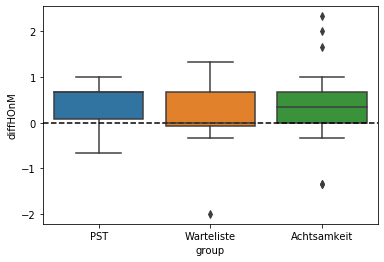

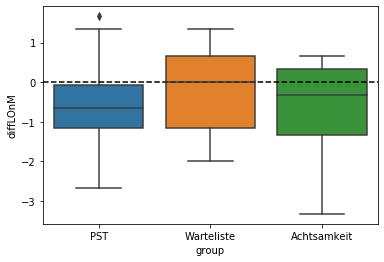

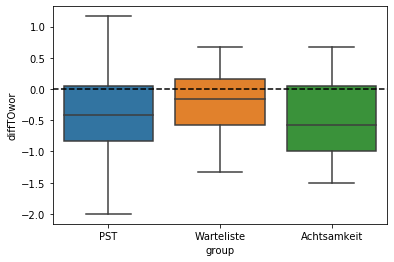

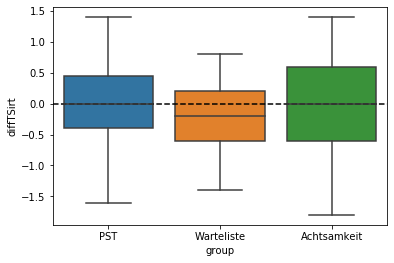

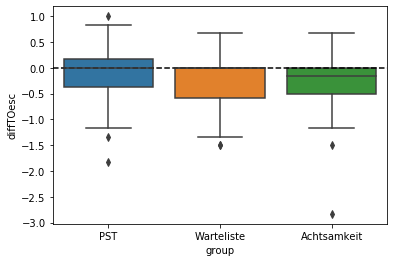

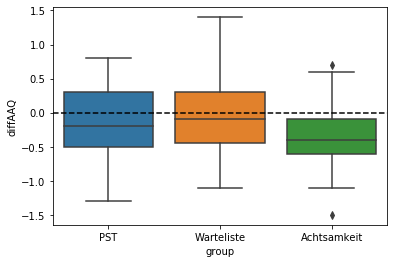

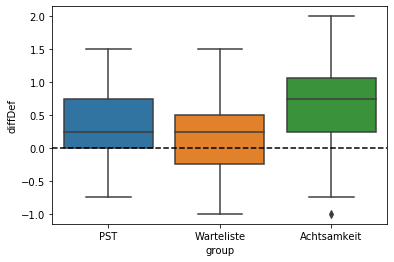

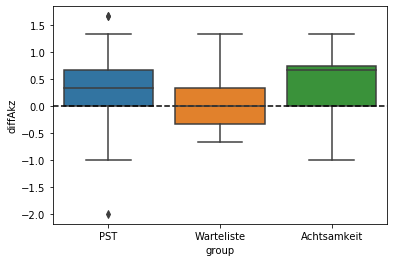

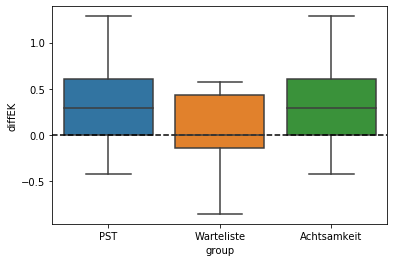

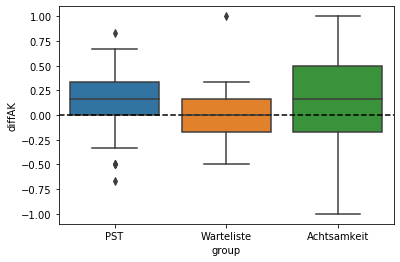

In [7]:
## plot all outcome diffs
for var in mainoutcomes:
  ax = sns.boxplot(x="group", y= var, data=dphil)
  ax.axhline(0, ls = "--", c = "black")
  plt.show()

## Step 2: Group-comparison of pre-post differences within every outcome variable


Build a sampling-function first - then test it:


In [0]:
## build a function for tha pymc3-model and tha evaluation of the pre post diff

def pre_post_btrace(var, scalemax, n = 100000, data = dphil):

  """
  ANALYSE PRE-POST DIFFERENCE OF A VARIABLE IN THE THREE GROUPS.

  var = string of outcome variable for which pre-post-diff should be analysed
  scalemax = integer indicating the max value of the questionnaire-item

  functions returns burned trace of mcmc sampling.
  """

  ### define model 1

  # observations
  # groups: (1=Achtsamkeit, 2=PST, 3=Kontrollgruppe)
  change_mind = data.loc[(data['group'] == "Achtsamkeit"), var]
  change_pst  = data.loc[(data['group'] == "PST"), var]
  change_cont = data.loc[(data['group'] == "Warteliste"), var]

  # model -- with uniform priors
  with pm.Model() as model: 
      
      # priors
      # as the scale goes only from 1 to scalemax: changes must be between -(scalemax - 1) and (scalemax - 1)
      p_mind = pm.Uniform("p_mind", -(scalemax - 1), (scalemax - 1)) 
      p_pst  = pm.Uniform("p_pst",  -(scalemax - 1), (scalemax - 1))
      p_cont = pm.Uniform("p_cont", -(scalemax - 1), (scalemax - 1))
      
      sigma = pm.HalfNormal('sigma', sd=10) # sd = 10 arbitrary, but robust (1 or 10000 not much different)
      
      # Define the deterministic eff functions. This is our unknown of interest.
      p_eff_mind = pm.Deterministic("p_eff_mind", p_mind - p_cont)
      p_eff_pst  = pm.Deterministic("p_eff_pst", p_pst - p_cont)
      p_mind_vs_pst  = pm.Deterministic("p_mind_vs_pst", p_mind - p_pst)
      
      # set of observations (likelihood distribution)
      obs_mind = pm.Normal("obs_mind", mu = p_mind, sd = sigma, observed = change_mind)
      obs_cont = pm.Normal("obs_cont", mu = p_cont, sd = sigma, observed = change_cont)    
      obs_pst  = pm.Normal("obs_pst",  mu = p_pst , sd = sigma, observed = change_pst)
      
      # mcmc sampling
      step = pm.Metropolis()
      trace = pm.sample(n, step=step) 
      burned_trace = trace[1000::2] #first 1000 gone, and every 2nd in rest

      # and return trace
      return(burned_trace)

In [9]:
## test function with one variable
trace_test = pre_post_btrace(var = "diffmind1nr", scalemax = 5, n = 10000, data = dphil)

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1828.89it/s]
The number of effective samples is smaller than 10% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7736cb7f98>,
      dtype=object)

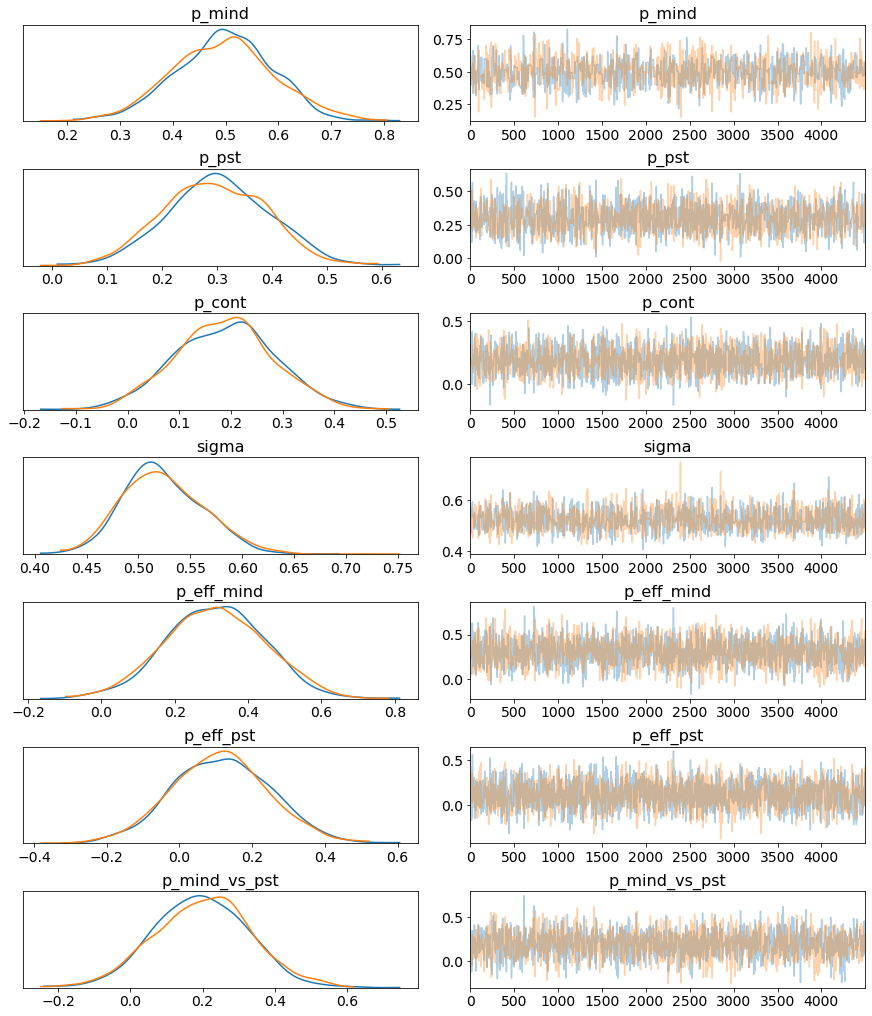

In [10]:
az.plot_trace(trace_test) # looks good

In [11]:
pm.gelman_rubin(trace_test) #good. Values close to 1.0 mean convergence.

{'p_cont': 1.0000229223389225,
 'p_eff_mind': 0.9998897696734377,
 'p_eff_pst': 1.000680423473297,
 'p_mind': 1.0000557012073013,
 'p_mind_vs_pst': 1.0006286974941883,
 'p_pst': 1.0026075263494094,
 'sigma': 1.0001260764968296}

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7737198ac8>,
      dtype=object)

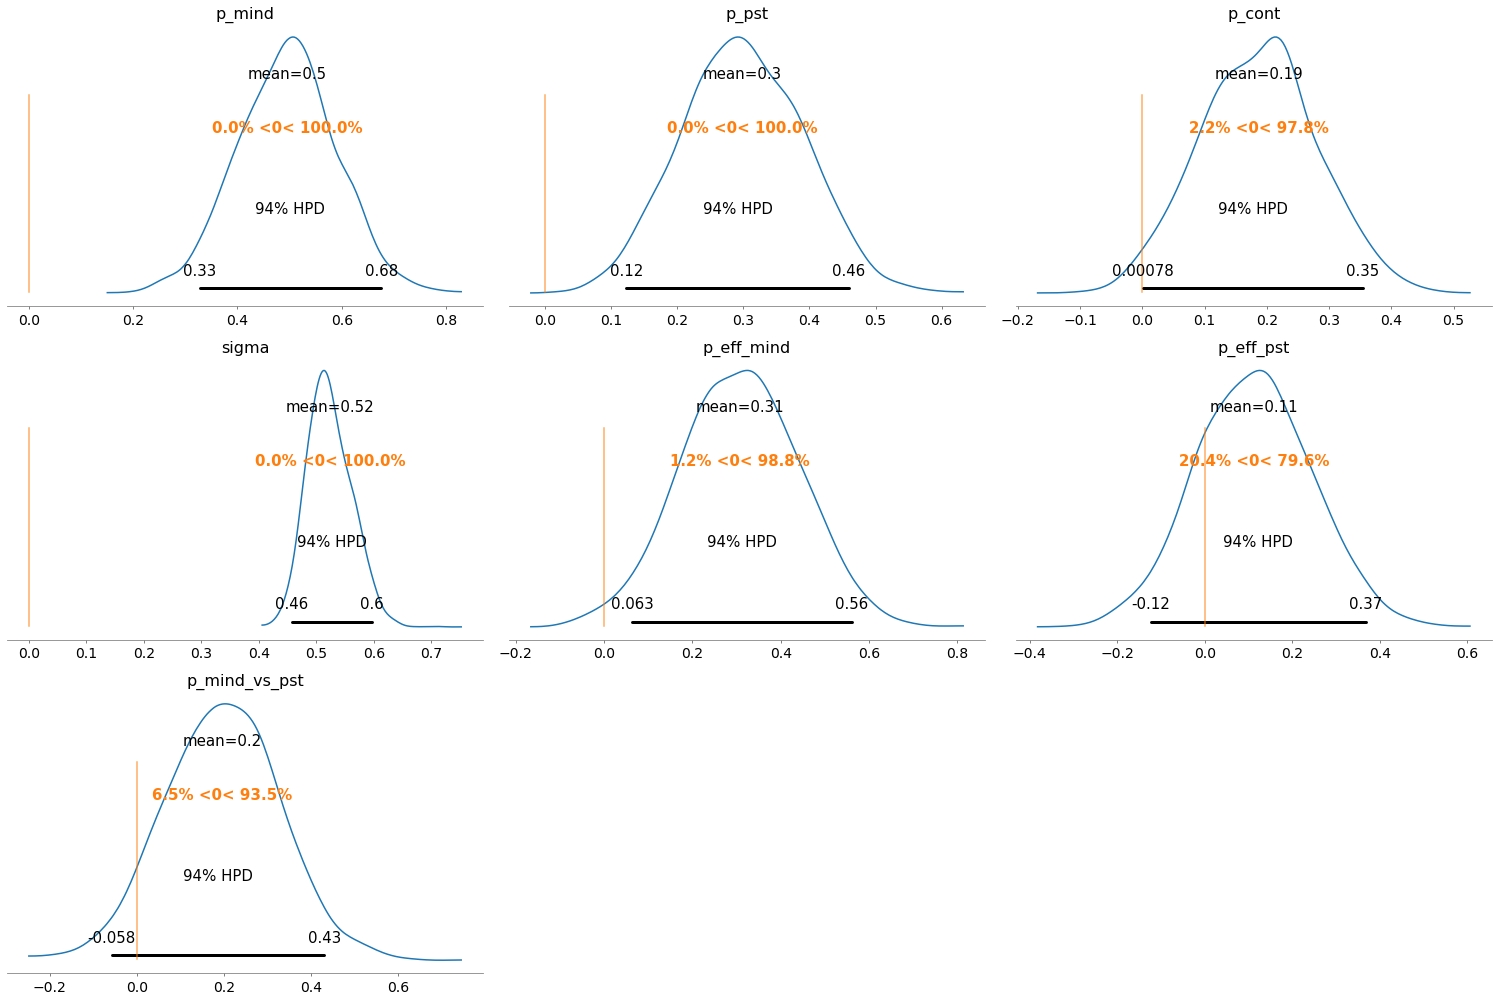

In [12]:
az.plot_posterior(trace_test,  ref_val= 0) # looks good too

In [13]:
az.summary(trace_test) #ok

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p_mind,0.495,0.094,0.328,0.675,0.003,0.002,1140.0,1140.0,1134.0,1033.0,1.01
p_pst,0.299,0.092,0.123,0.460,0.002,0.002,1716.0,1679.0,1733.0,1621.0,1.00
p_cont,0.187,0.094,0.001,0.354,0.002,0.002,2036.0,1897.0,2045.0,2097.0,1.00
sigma,0.523,0.038,0.457,0.597,0.001,0.001,1599.0,1597.0,1628.0,1666.0,1.00
p_eff_mind,0.308,0.134,0.063,0.561,0.003,0.002,1478.0,1478.0,1478.0,2001.0,1.00
p_eff_pst,0.112,0.132,-0.123,0.368,0.003,0.002,1837.0,1837.0,1842.0,2460.0,1.00
p_mind_vs_pst,0.196,0.131,-0.058,0.431,0.003,0.002,1466.0,1466.0,1462.0,1748.0,1.00


(-5, 5)

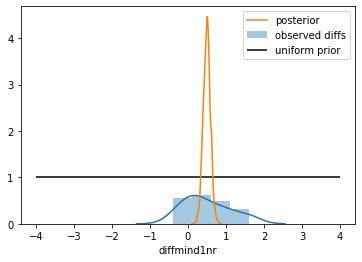

In [24]:
# show prior, data (likelihood) and posterior in same plot
sns.distplot(dphil.loc[(dphil['group'] == "Achtsamkeit"), "diffmind1nr"], hist = True, label = "observed diffs") # the observed change in mindfullness-group
plt.hlines(y = 1,xmin = -4,xmax = 4 , label = "uniform prior")
sns.distplot(trace_test["p_mind"], hist = False, label = "posterior")
ax.set_xlim(-5,5)

# sweet! but is the posterior-dist not too narrow? can that be true?

In [16]:
# and finally finally:
# Count the number of samples less than 0, i.e. the area under the curve
# before 0, represent the probability that site A is worse than site B.
print("Effects on variable '{}':".format("bla"))

# for mind
print("Probability intervention MIND is BETTER than CONT: %.3f" % \
    np.mean(trace_test["p_eff_mind"] > 0))

# for pst
print("Probability intervention PST is BETTER than CONT: %.3f" % \
    np.mean(trace_test["p_eff_pst"] > 0))

# and for the difference mind - pst
print("Probability intervention MIND is BETTER than PST: %.3f" % \
    np.mean(trace_test["p_mind_vs_pst"] > 0))

print()

Effects on variable 'bla':
Probability intervention MIND is BETTER than CONT: 0.988
Probability intervention PST is BETTER than CONT: 0.796
Probability intervention MIND is BETTER than PST: 0.935



Apply the above to all interesting variables:

In [17]:
## interesting variables and the respective scalemaxes

# vars
print(len(outcomes))

# scalemaxes
scmax = [5,5,5,5,5,5,5,5,5,5,7,7,7,7,7,7,5,5,5,5] #from indications by sho
print(len(scmax))

20
20


In [18]:
## now the big loop:

# time at start
start = time.time()

# prepare results-list
trace_list = [] #resulting trace list

for i in range(len(outcomes)):
  
  # execute mcmc
  trace_res = pre_post_btrace(outcomes[i], scmax[i], n = 10000, data = dphil)
  
  # append trace to results-list
  trace_list.append(trace_res)

  # print status
  print("MCMC for {} executed.".format(outcomes[i]))
  print()


# time at end
end = time.time()

# duration
print()
print()
print("The sampling took {} minutes.".format(round((end - start)/60,2)))

Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1843.23it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffmind1nr executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1759.51it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffmin2nj executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1931.66it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffmind3a executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1775.17it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffEZF executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1821.55it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffSG executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1868.99it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffV executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1920.82it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffE executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1818.61it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffA executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1891.97it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffETEK executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1772.96it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffETAK executed.



/usr/local/lib/python3.6/dist-packages/pymc3/model.py:1331: UserWarning: Data in obs_mind contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/usr/local/lib/python3.6/dist-packages/pymc3/model.py:1331: UserWarning: Data in obs_cont contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/usr/local/lib/python3.6/dist-packages/pymc3/model.py:1331: UserWarning: Data in obs_pst contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [obs_pst_missing]
>Metropolis: [obs_cont_missing]
>Metropolis: [obs_mind_missing]
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:12<00:00, 815.16it/s]
The estimated number of effective sam

MCMC for diffHOnM executed.



/usr/local/lib/python3.6/dist-packages/pymc3/model.py:1331: UserWarning: Data in obs_mind contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/usr/local/lib/python3.6/dist-packages/pymc3/model.py:1331: UserWarning: Data in obs_cont contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/usr/local/lib/python3.6/dist-packages/pymc3/model.py:1331: UserWarning: Data in obs_pst contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [obs_pst_missing]
>Metropolis: [obs_cont_missing]
>Metropolis: [obs_mind_missing]
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:12<00:00, 827.92it/s]
The estimated number of effective sam

MCMC for diffLOnM executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1883.12it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffTOwor executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:06<00:00, 1715.43it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffTSirt executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1798.32it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffTOesc executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1800.51it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffAAQ executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1771.87it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffDef executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1923.08it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffAkz executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1889.55it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffEK executed.



Sequential sampling (2 chains in 1 job)
CompoundStep
>Metropolis: [sigma]
>Metropolis: [p_cont]
>Metropolis: [p_pst]
>Metropolis: [p_mind]
100%|██████████| 10500/10500 [00:05<00:00, 1787.81it/s]
The number of effective samples is smaller than 10% for some parameters.


MCMC for diffAK executed.



The sampling took 5.66 minutes.


In [19]:
len(trace_list)

20

In [21]:
## now iterate over trace list and print results

for i in range(len(outcomes)):
  
  print("Effects on variable '{}':".format(outcomes[i]))

  # for mind
  print("Probability intervention MIND is BETTER than CONT: %.3f" % \
      np.mean(trace_list[i]["p_eff_mind"] > 0))

  # for pst
  print("Probability intervention PST is BETTER than CONT: %.3f" % \
      np.mean(trace_list[i]["p_eff_pst"] > 0))

  # and for the difference mind - pst
  print("Probability intervention MIND is BETTER than PST: %.3f" % \
      np.mean(trace_list[i]["p_mind_vs_pst"] > 0))

  print()

Effects on variable 'diffmind1nr':
Probability intervention MIND is BETTER than CONT: 0.984
Probability intervention PST is BETTER than CONT: 0.814
Probability intervention MIND is BETTER than PST: 0.919

Effects on variable 'diffmin2nj':
Probability intervention MIND is BETTER than CONT: 0.975
Probability intervention PST is BETTER than CONT: 0.431
Probability intervention MIND is BETTER than PST: 0.979

Effects on variable 'diffmind3a':
Probability intervention MIND is BETTER than CONT: 0.569
Probability intervention PST is BETTER than CONT: 0.412
Probability intervention MIND is BETTER than PST: 0.657

Effects on variable 'diffEZF':
Probability intervention MIND is BETTER than CONT: 0.952
Probability intervention PST is BETTER than CONT: 0.987
Probability intervention MIND is BETTER than PST: 0.325

Effects on variable 'diffSG':
Probability intervention MIND is BETTER than CONT: 0.581
Probability intervention PST is BETTER than CONT: 0.946
Probability intervention MIND is BETTER tha

### Sweet, step 2 finished.

Report the following to Phil and Stephan:

- Probabilities of MIND and PST being better than CONT for every variable.

---


## Step 3: Bayesian GLM


In [0]:
## prepare

# formula
formula = "diffmind1nr ~  sex + formellachts + formellpst"

In [26]:
## implement the GLM
with pm.Model() as glm_mod:
    
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = dphil, family = family)
    
    # Perform Markov Chain Monte Carlo sampling
    glm_mod_trace = pm.sample(draws=2000, chains = 2, tune = 500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, formellpst, formellachts, sex[T.weiblich], Intercept]
100%|██████████| 2500/2500 [00:04<00:00, 599.55it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f771eb02f60>,
      dtype=object)

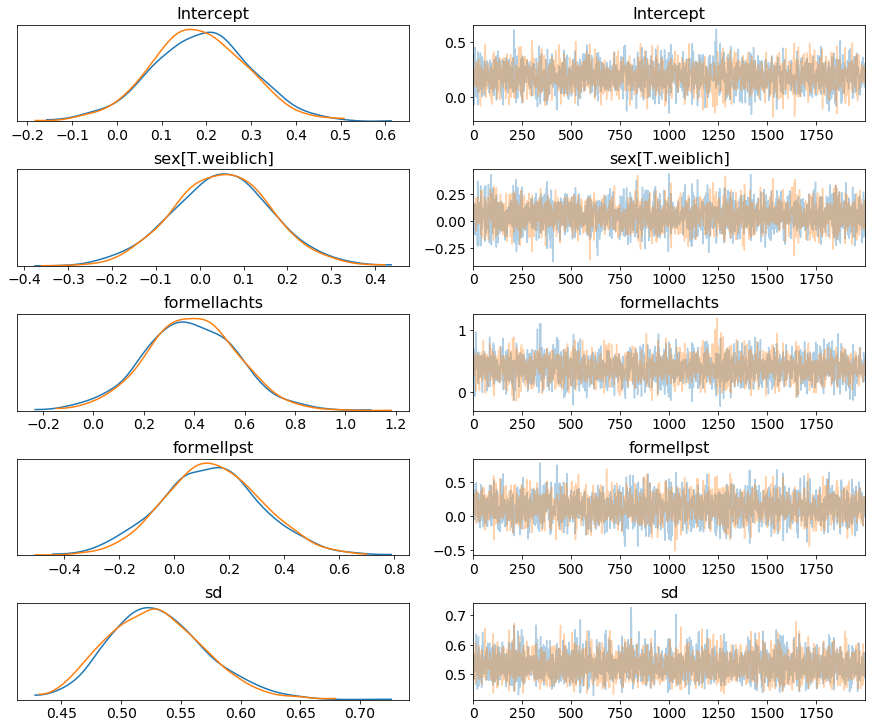

In [27]:
## investigate results
az.plot_trace(glm_mod_trace) # looks good

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f771f226320>,
      dtype=object)

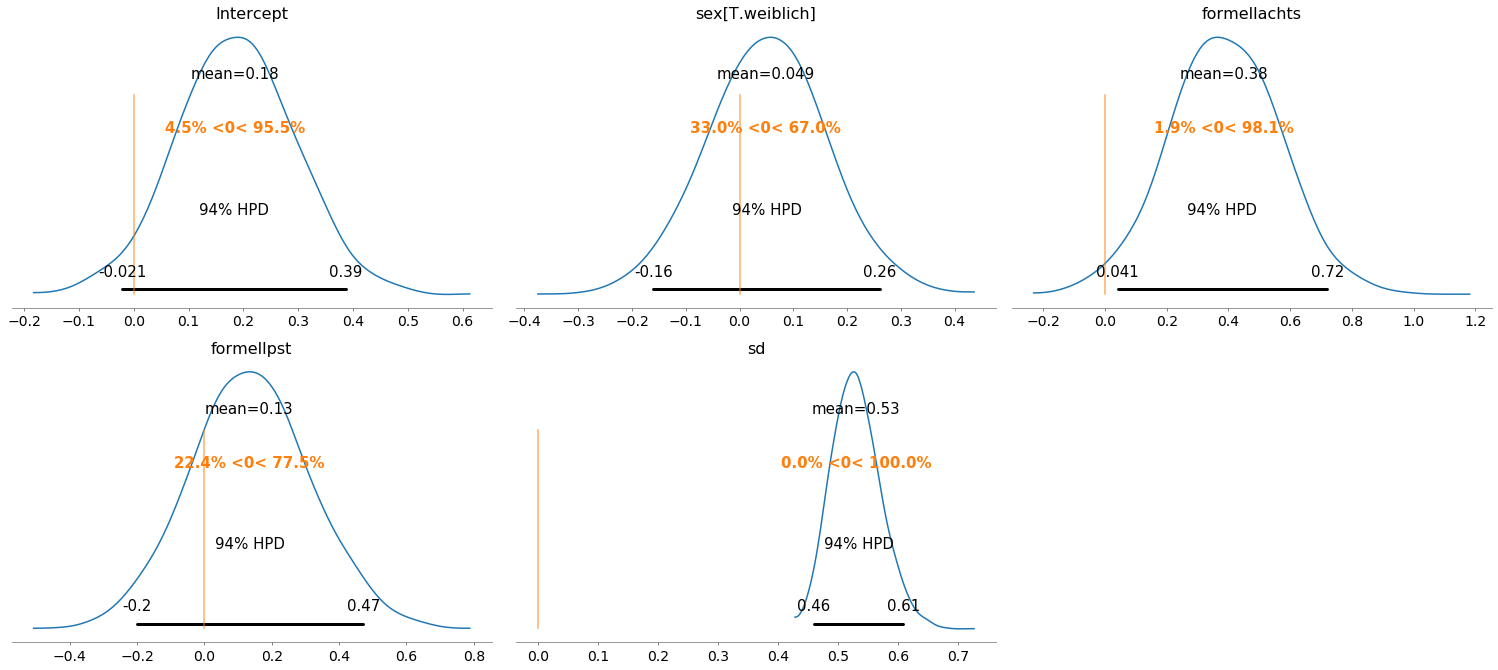

In [28]:
az.plot_posterior(glm_mod_trace,  ref_val= 0) # looks good too

In [0]:
az.summary(glm_mod_trace) #ok

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.597,0.410,-0.159,1.387,0.010,0.007,1579.0,1579.0,1580.0,1920.0,1.0
group[T.PST],-0.298,0.679,-1.563,0.948,0.016,0.012,1750.0,1634.0,1749.0,1812.0,1.0
group[T.Warteliste],-0.438,0.414,-1.187,0.368,0.010,0.007,1596.0,1596.0,1595.0,2016.0,1.0
sex[T.weiblich],0.052,0.111,-0.150,0.263,0.002,0.002,3506.0,1900.0,3517.0,2494.0,1.0
formellachts,-0.184,0.572,-1.225,0.915,0.015,0.010,1552.0,1552.0,1552.0,1985.0,1.0
formellpst,-0.028,0.765,-1.482,1.364,0.016,0.012,2369.0,1874.0,2318.0,2289.0,1.0
sd,0.533,0.041,0.458,0.609,0.001,0.001,3286.0,3234.0,3334.0,2586.0,1.0


Tnis mians that: - correct?

diffmind1nr ~ N(diffmind1nr ~ 0.597 + -0.298*group[T.PST] + -0.438*group[T.Warteliste] + 0.052*sex[T.weiblich] + -0.184-formellachts + -0.028*formellpst,  0.533^2)



## Step z: Restcode and notes



and finally, the bayes factors via marginal likelihods

 seems not so easy?! see:

 https://stats.stackexchange.com/questions/161082/bayesian-model-selection-in-pymc3
 https://docs.pymc.io/notebooks/Bayes_factor.html
 http://stronginference.com/bayes-factors-pymc.html
 https://stats.stackexchange.com/questions/77041/bayes-factor-for-testing-a-null-hypothesis
 https://docs.pymc.io/notebooks/BEST.html

Oder einfach likelihood-ration verwenden?

"The likelihood at the MLE is just a point estimate of the Bayes factor numerator and denominator, respectively."

... using the cauchy-likelihood, the posteriors are a bit wider (and effects less clear...). why? because beta (cauchy) = sd (normal) angenommen?

unsicher hier...

wohl ist es das beste, das model 2 zu nehmen und die priors noch an literaturwerte anzupassen...  

- Group comparisons wie hier: https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

- irgendwie noch bayes factors errechnen

- dann mit lässigem for-loop über alle vars laufen lassen

- sequential monte carlo probieren (für bayes factors via marginal likelihoode): https://docs.pymc.io/notebooks/Bayes_factor.html (s beispiel unten)

- bayes factors / likelihood ratios / marginal likelihood nochmals überlegen und dann berechnen:

  - The Bayes factor is a likelihood ratio of the marginal likelihood of two competing hypotheses, usually a null and an alternative.
  - https://en.wikipedia.org/wiki/Bayes_factor#Example
  - The real difference is that likelihood ratios are cheaper to compute and generally conceptually easier to specify. The likelihood at the MLE is just a point estimate of the Bayes factor numerator and denominator, respectively. Like most frequentist constructions, it can be viewed as a special case of Bayesian analysis with a contrived prior that's hard to get at. But mostly it arose because it's analytically tractable and easier to compute (in the era before approximate Bayesian computational approaches arose).





#### articles on bayesian linear regression:

https://towardsdatascience.com/bayesian-linear-regression-in-python-using-machine-learning-to-predict-student-grades-part-2-b72059a8ac7e

https://www.quantstart.com/articles/Bayesian-Linear-Regression-Models-with-PyMC3

https://towardsdatascience.com/introduction-to-bayesian-linear-regression-e66e60791ea7

https://www.kaggle.com/sathi557/bayesian-linear-regression-demo

restcode for estimation or marginal likelihood:

In [0]:
# model -- with sequential monte carlo (nur ausprobieren). 

# observations
# groups: (1=Achtsamkeit, 2=PST, 3=Kontrollgruppe)
change_gr1 = dphil3.loc[(dphil3['group'] == 1), 'change']
change_gr2 = dphil3.loc[(dphil3['group'] == 2), 'change']
change_gr3 = dphil3.loc[(dphil3['group'] == 3), 'change']

with pm.Model() as model_smc: 
    
    # priors
    # as the scale goes only from 1 to 5: changes must be between -4 and 4
    p_mind = pm.Uniform("p_mind", -4, 4) 
    p_pst  = pm.Uniform("p_pst",  -4, 4) 
    p_cont = pm.Uniform("p_cont", -4, 4)
    
    sigma = pm.HalfNormal('sigma', sd=1) # 1 too arbitrary?
    
    # Define the deterministic eff functions. This is our unknown of interest.
    p_eff_mind = pm.Deterministic("p_eff_mind", p_mind - p_cont)
    p_eff_pst  = pm.Deterministic("p_eff_pst", p_pst - p_cont)
    
    ## likelihood distribution
    obs_mind = pm.Cauchy("obs_mind", alpha = p_mind, beta = sigma, observed = change_gr1)
    obs_cont = pm.Cauchy("obs_cont", alpha = p_cont, beta = sigma, observed = change_gr3)    
    obs_pst  = pm.Cauchy("obs_pst",  alpha = p_pst , beta = sigma, observed = change_gr2)
    
    # start = pm.find_MAP() #apparantly not good
    step = pm.SMC()
    trace_smc = pm.sample(10000, step=step,  random_seed = 666) #only 10^4
    burned_trace_smc = trace_smc[1000::2]

Sample initial stage: ...
Stage: 0 Beta: 0.015 Steps: 25
100%|██████████| 10000/10000 [00:17<00:00, 558.98it/s]
Stage: 1 Beta: 0.033 Steps: 14
100%|██████████| 10000/10000 [00:10<00:00, 987.31it/s]
Stage: 2 Beta: 0.056 Steps: 3
100%|██████████| 10000/10000 [00:02<00:00, 3906.61it/s]
Stage: 3 Beta: 0.097 Steps: 11
100%|██████████| 10000/10000 [00:08<00:00, 1238.20it/s]
Stage: 4 Beta: 0.183 Steps: 3
100%|██████████| 10000/10000 [00:02<00:00, 3902.92it/s]
Stage: 5 Beta: 0.366 Steps: 8
100%|██████████| 10000/10000 [00:05<00:00, 1728.17it/s]
Stage: 6 Beta: 0.773 Steps: 4
100%|██████████| 10000/10000 [00:03<00:00, 3023.94it/s]
Stage: 7 Beta: 1.000 Steps: 6
100%|██████████| 10000/10000 [00:04<00:00, 2103.90it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c868f9eb8>,
      dtype=object)

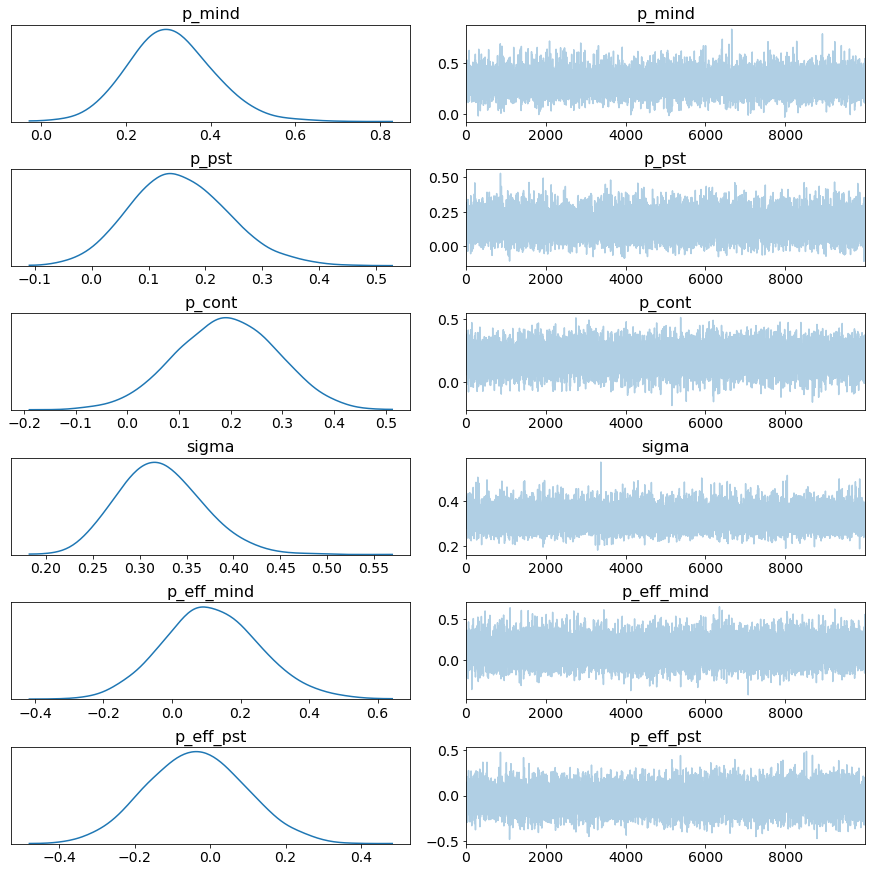

In [0]:
az.plot_trace(trace_smc) #doesnt meander - good

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7c7b9ab358>,
      dtype=object)

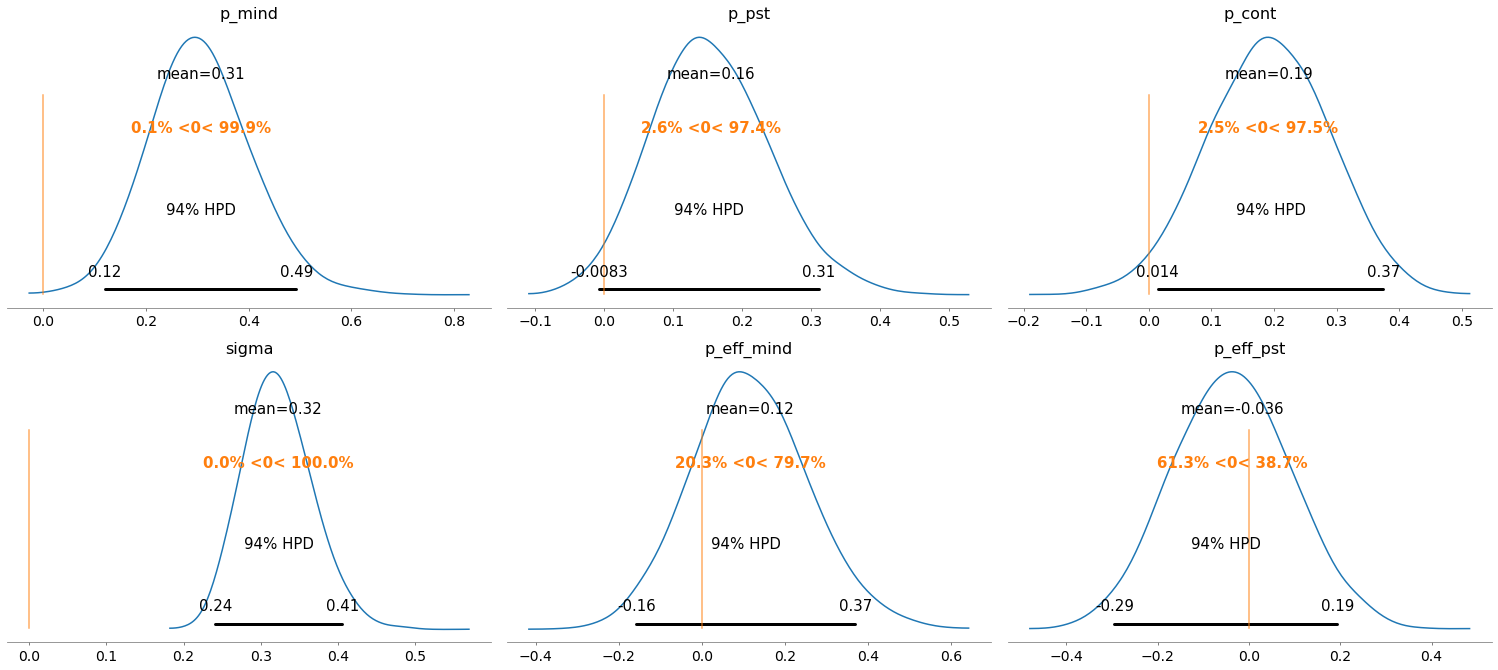

In [0]:
az.plot_posterior(trace_smc,  ref_val= 0)

In [0]:
az.summary(trace_smc)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
p_mind,0.307,0.100,0.121,0.493,0.001,0.001,10226.0,10067.0,10269.0,10004.0,NaN
p_pst,0.155,0.085,-0.008,0.311,0.001,0.001,9725.0,9725.0,9694.0,9625.0,NaN
p_cont,0.191,0.097,0.014,0.375,0.001,0.001,10102.0,10102.0,10110.0,9794.0,NaN
sigma,0.323,0.045,0.241,0.406,0.000,0.000,9549.0,9517.0,9576.0,9748.0,NaN
p_eff_mind,0.116,0.140,-0.158,0.370,0.001,0.001,10276.0,9892.0,10294.0,9894.0,NaN
p_eff_pst,-0.036,0.130,-0.294,0.193,0.001,0.001,9965.0,9619.0,9957.0,9178.0,NaN


In [0]:
model_smc.marginal_likelihood #mrginal likelihood of one whole model! so different models must be specified to derive a bayes factor?! (via ration of marginal likelihood)

2.2604622756692446e-45